Wikidata5M
-------
Wikidata5M
-------
Wikidata5M
-------
Wikidata5M
-------


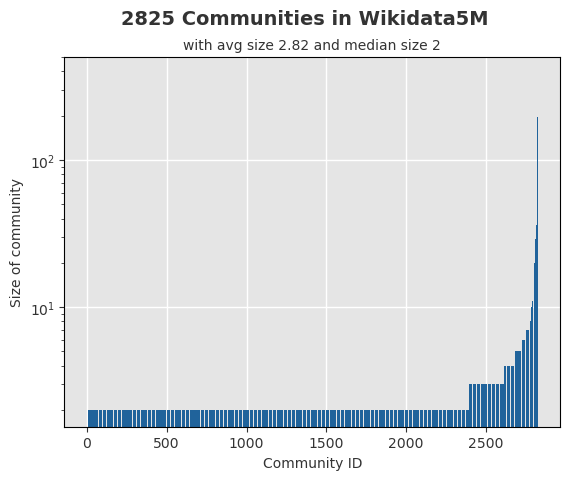

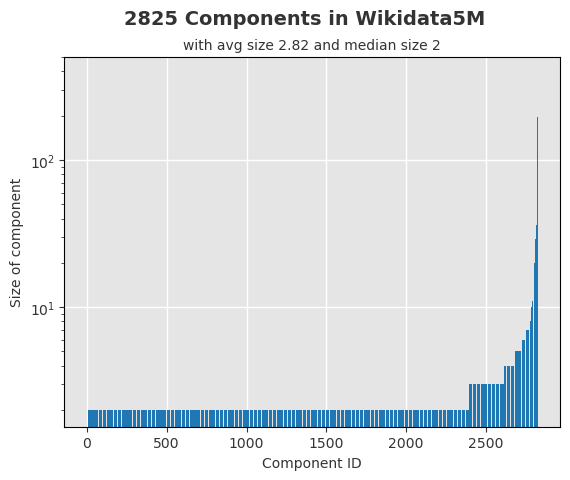

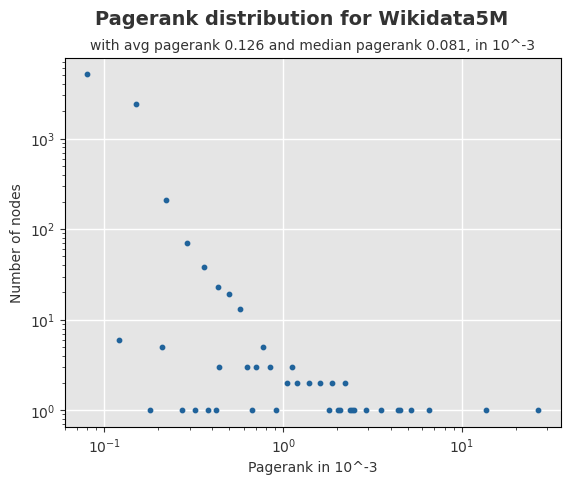

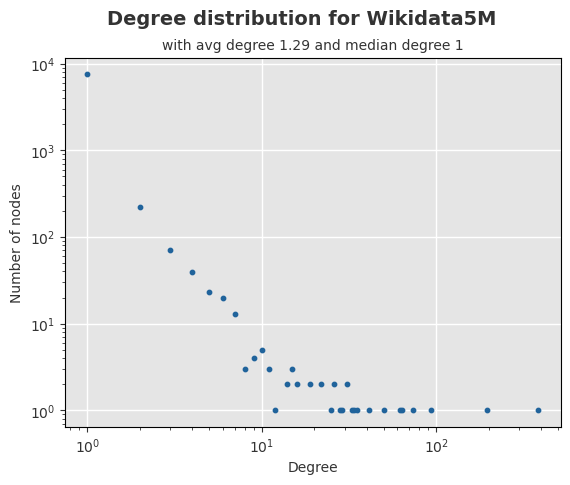

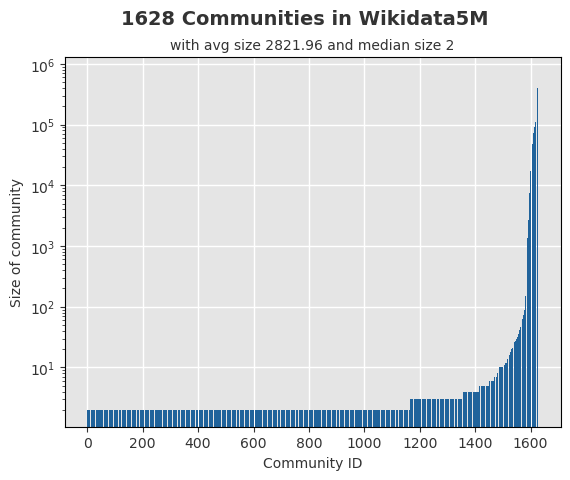

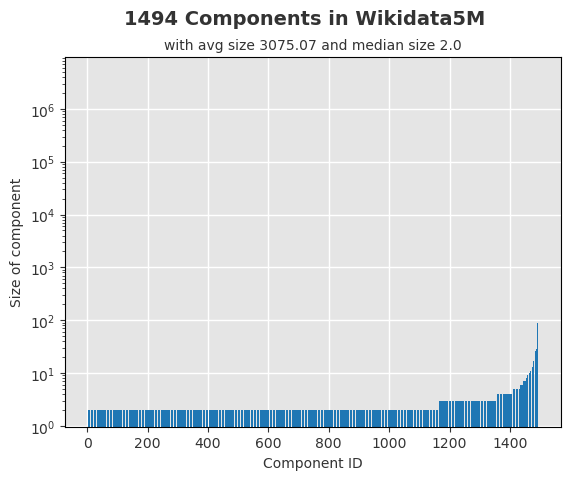

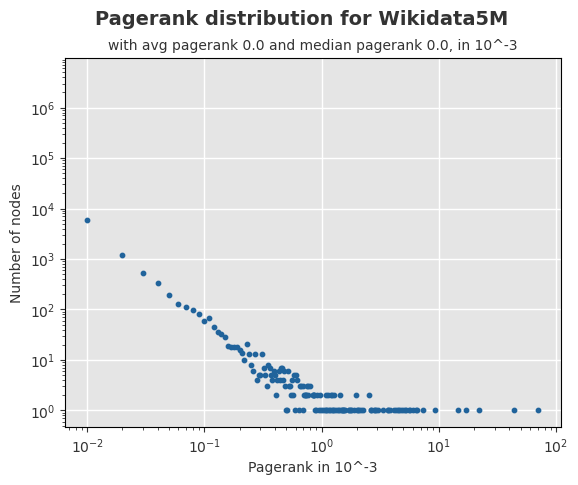

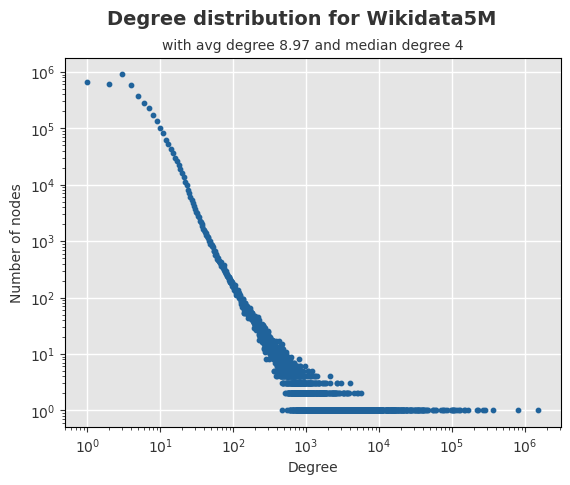

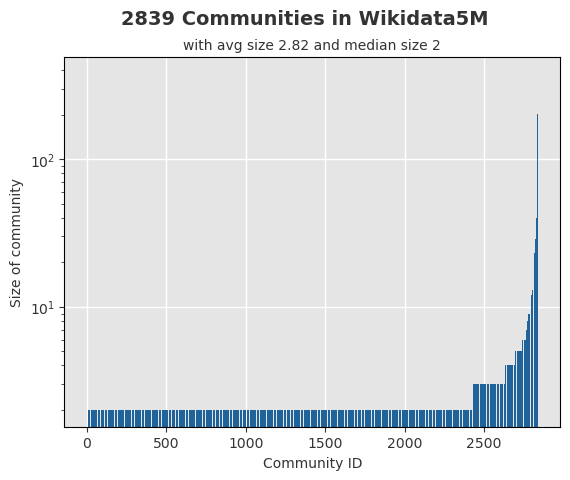

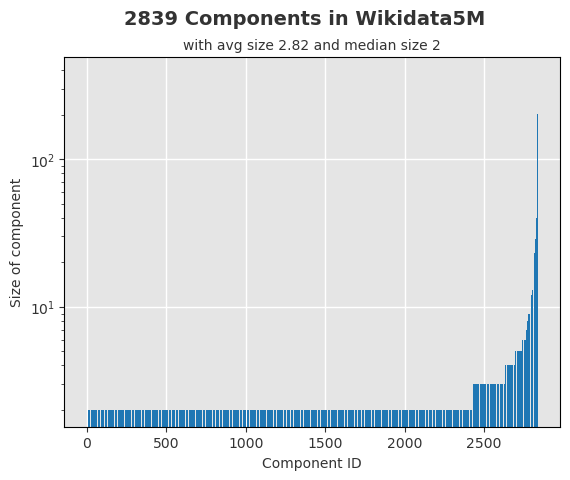

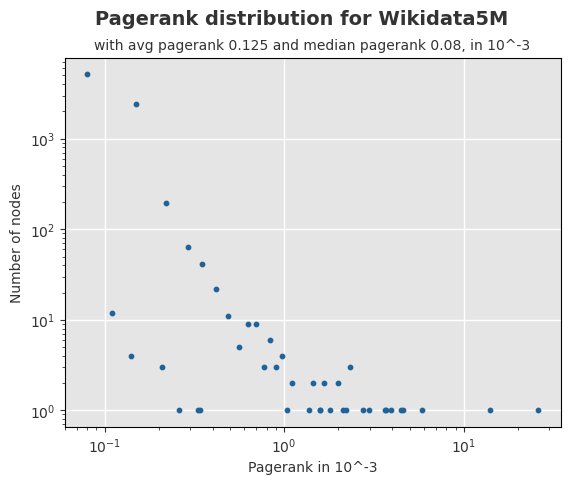

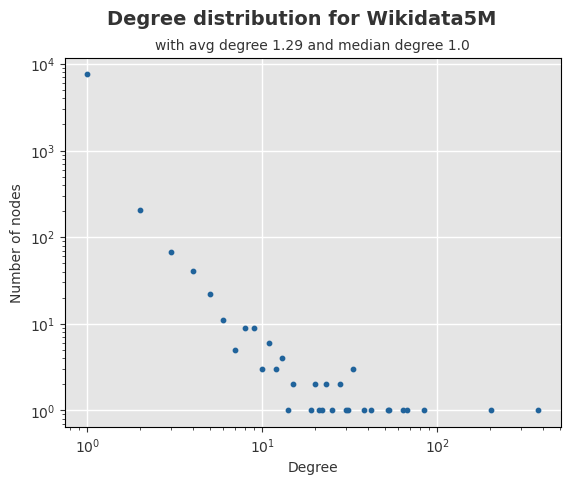

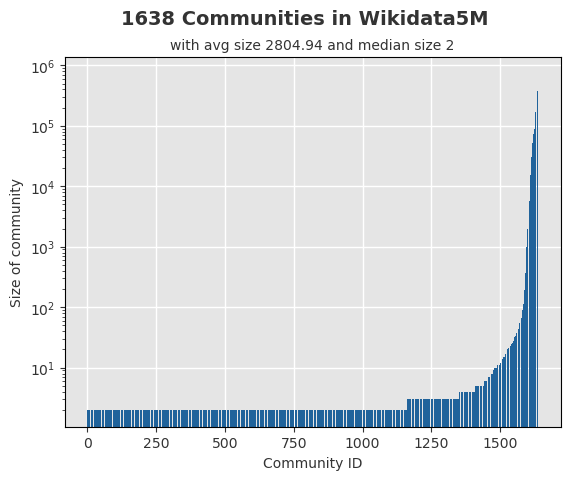

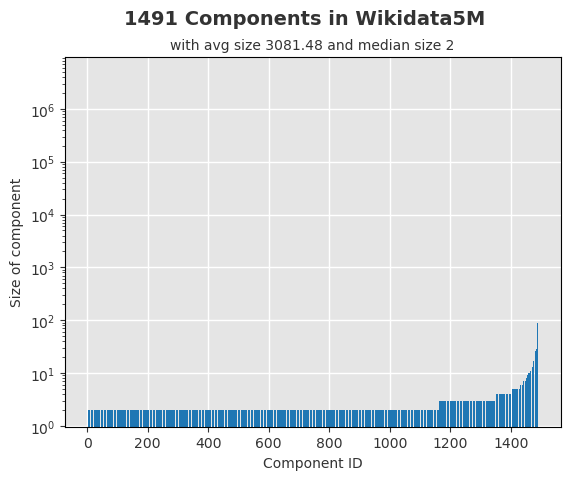

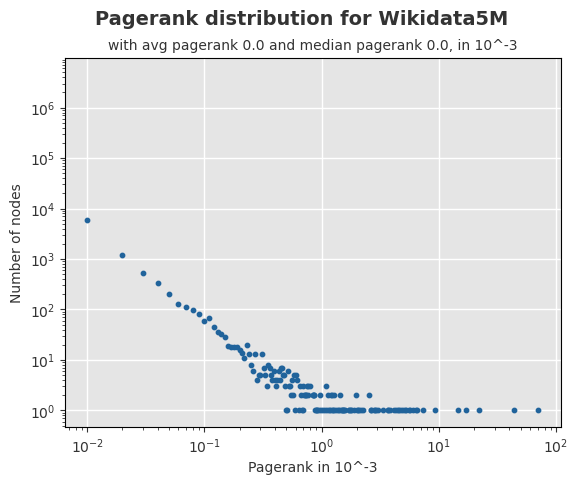

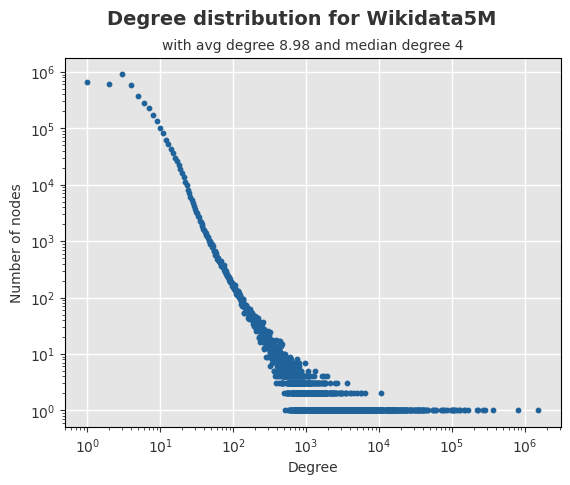

In [1]:
import os
import pandas as pd
import networkx as nx
import networkx.algorithms.community as nx_com
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
from collections import Counter
import numpy as np
from statistics import mean
from statistics import median

data_dir = os.getcwd() + "/../data/"

# Get a list of all folders in data directory
dataset_folders = [f for f in os.listdir(data_dir) if os.path.isdir(data_dir + f)]

for partition in "test", "train", "valid", "merged":
    community_output_dir = os.getcwd() + "/data/network_analysis/communities/{}".format(partition)
    components_output_dir = os.getcwd() + "/data/network_analysis/components/{}".format(partition)
    degree_output_dir = os.getcwd() + "/data/network_analysis/degree/{}".format(partition)
    pagerank_output_dir = os.getcwd() + "/data/network_analysis/pagerank/{}".format(partition)
    graphics_output_dir = os.getcwd() + "/output/network_analysis/{}/".format(partition)
    for dataset in dataset_folders:
        df = pd.read_csv(data_dir + "/{}/CSVFiles/{}.csv".format(dataset, partition))
        directedGraph = nx.from_pandas_edgelist(df, 'head', 'tail', edge_attr="predicate", create_using=nx.DiGraph)
        
        undirectedGraph = nx.from_pandas_edgelist(df, 'head', 'tail')
        components = nx.connected_components(undirectedGraph)
        component_sizes = sorted([len(component) for component in components])
        communities = nx_com.louvain_communities(undirectedGraph)
        pageranks = nx.pagerank(directedGraph)
        # We save pageranks in 10^-3 
        pageranks = [pagerank * 1000 for pagerank in pageranks.values()]
        degrees = [entry[1] for entry in nx.degree(directedGraph)]
        community_sizes = sorted([len(community) for community in communities])
        
        pagerank_distribution = Counter([round(pr, 2) for pr in pageranks])
        degree_distribution = Counter(degrees)

        print(dataset, partition)
        print("-------")
        output_dirs = [community_output_dir, components_output_dir, degree_output_dir, pagerank_output_dir, graphics_output_dir]
        for directory in output_dirs:
            if not os.path.exists(directory):
                os.makedirs(directory)
        
        
        for folder in "communities", "components", "degree", "pagerank":
            if not os.path.exists(graphics_output_dir + folder):
                os.makedirs(graphics_output_dir + folder)
        
        # Write communities and their size to a CSV file
        with open(community_output_dir + "/{}.csv".format(dataset), "w") as writer:
            writer.write("CommunityID,Size\n")
            for i, community in enumerate(communities):
                writer.write("{},{}\n".format(i, len(community)))

        # Write components and their size to a CSV file
        with open(components_output_dir + "/{}.csv".format(dataset), "w") as writer:
            writer.write("ComponentID,Size\n")
            for i, size in enumerate(component_sizes):
                writer.write("{},{}\n".format(i, size))
        
        # Write degree distribution to a CSV file
        with open(degree_output_dir + "/{}.csv".format(dataset), "w") as writer:
            writer.write("Degree,Count\n")
            for degree, count in degree_distribution.items():
                writer.write("{},{}\n".format(degree, count))

        # Write pagerank distribution to a CSV file
        with open(pagerank_output_dir + "/{}.csv".format(dataset), "w") as writer:
            writer.write("PageRank,Count\n")
            for pr, count in pagerank_distribution.items():
                writer.write("{},{}\n".format(pr, count))
    
        plt.rcParams['axes.facecolor'] = '#e5e5e5'
        plt.rcParams['axes.grid'] = True
        plt.rcParams['grid.alpha'] = 1
        plt.rcParams['grid.linewidth'] = 1
        plt.rcParams['grid.color'] = "#ffffff"
        plt.rcParams['axes.axisbelow'] = True
        label_color = '#333333'
        primaryColor = '#20639b'
        plt.rcParams['text.color'] = label_color
        plt.rcParams['axes.labelcolor'] = label_color
        plt.rcParams['xtick.color'] = label_color
        plt.rcParams['ytick.color'] = label_color

        # Create community sizes diagram
        fig, ax = plt.subplots()
        plt.yscale('log')
        ax.bar(range(len(community_sizes)), community_sizes, color=primaryColor)
        fig.suptitle("{} Communities in {}".format(len(community_sizes),dataset), fontsize=14, fontweight="bold",)
        ax.set_title("with avg size {} and median size {}".format(round(mean(community_sizes), 2), round(median(community_sizes))), fontsize=10)
        ax.set_xlabel('Community ID', fontsize=10)
        ax.set_ylabel('Size of community', fontsize=10)
        fig.savefig(graphics_output_dir + 'communities/{}.png'.format(dataset), dpi=300)

        # Create component sizes diagram
        fig, ax = plt.subplots()
        plt.yscale('log')
        ax.bar(range(len(component_sizes)), component_sizes)
        fig.suptitle("{} Components in {}".format(len(component_sizes),dataset),fontsize=14, fontweight="bold",)
        ax.set_title("with avg size {} and median size {}".format(round(mean(component_sizes), 2), round(median(component_sizes), 2)), fontsize=10)
        ax.set_xlabel('Component ID', fontsize=10)
        ax.set_ylabel('Size of component', fontsize=10)
        fig.savefig(graphics_output_dir + 'components/{}.png'.format(dataset), dpi=500)

        # Create pagerank diagram
        pagerank_x = pagerank_distribution.keys()
        pagerank_y = pagerank_distribution.values()
        fig, ax = plt.subplots()
        plt.yscale('log')
        plt.xscale('log')
        ax.scatter(pagerank_x, pagerank_y, c=primaryColor, s=10)
        fig.suptitle("Pagerank distribution for {} ".format(dataset),fontsize=14, fontweight="bold",)
        ax.set_title("with avg pagerank {} and median pagerank {}, in 10^-3".format(round(mean(pageranks), 3), round(median(pageranks), 3)), fontsize=10)
        ax.set_xlabel('Pagerank in 10^-3', fontsize=10)
        ax.set_ylabel('Number of nodes', fontsize=10)
        fig.savefig(graphics_output_dir + 'pagerank/{}.png'.format(dataset), dpi=300)

        # Create degree diagram
        degree_x = degree_distribution.keys()
        degree_y = degree_distribution.values()
        fig, ax = plt.subplots()
        plt.yscale('log')
        plt.xscale('log')
        ax.scatter(degree_x, degree_y, c=primaryColor, s=10)
        fig.suptitle("Degree distribution for {} ".format(dataset),fontsize=14, fontweight="bold",)
        ax.set_title("with avg degree {} and median degree {}".format(round(mean(degrees), 2), round(median(degrees), 2)), fontsize=10)
        ax.set_xlabel('Degree', fontsize=10)
        ax.set_ylabel('Number of nodes', fontsize=10)
        fig.savefig(graphics_output_dir + 'degree/{}.png'.format(dataset), dpi=300)


    
   
   




